## １次元畳み込みのサンプル
https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1
    
こちらを参考に。

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

### データの用意

In [5]:
timeline = np.arange(10000)
epochs = 100

def sinnp(n, line):
    return np.sin(line * n / 100)

def cosnp(n, line):
    return np.cos(line * n / 100)

raw_data = (sinnp(1, timeline) + sinnp(3, timeline) + sinnp(10, timeline) + cosnp(5, timeline) + cosnp(7, timeline)) / 5
raw_data = raw_data + (np.random.rand(len(timeline)) * 0.1)# ノイズ項

C:\Users\daich\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\daich\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\daich\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\daich\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 38291 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\daich\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\daich\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 23450 missing from curre

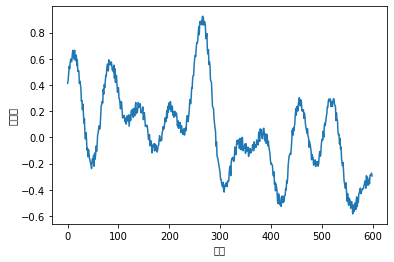

In [6]:
plt.plot(timeline[:600], raw_data[:600])
plt.xlabel("時間")
plt.ylabel("測定値")
plt.show()

### 入出力データの定義

- 64個の時系列データを元に、次の16個の時系列データを生成する

In [7]:
input_data = []
output_data = []

for n in range(10000-80):
    input_data.append(raw_data[n:n+64])
    output_data.append(raw_data[n+64:n+80])

input_data = np.array(input_data)
output_data = np.array(output_data)


In [8]:
input_data.shape, output_data.shape

((9920, 64), (9920, 16))

１次元畳み込みの注意点
- shape : (<シーケンス長>, <パラメータ数>)

In [10]:
train_X = np.reshape(input_data, (-1,64,1))
train_t = np.reshape(output_data, (-1,16,1))

train_X.shape, train_t.shape

((9920, 64, 1), (9920, 16, 1))

### モデルの作成

In [12]:
model = models.Sequential()

model.add(layers.Conv1D(64, 8, padding="same", input_shape=(64,1), activation="relu"))
model.add(layers.MaxPool1D(2, padding="same"))
model.add(layers.Conv1D(64, 8, padding="same", activation="relu"))
model.add(layers.MaxPool1D(2, padding="same"))
model.add(layers.Conv1D(32, 8, padding="same", activation="relu"))
model.add(layers.Conv1D(1, 8, padding="same", activation="tanh"))

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 64, 64)            576       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 32)            16416     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 1)             257       
Total params: 50,081
Trainable params: 50,081
Non-trainable params: 0
__________________________________________________

In [15]:
history = model.fit(train_X, train_t, validation_split=0.1, epochs=epochs)

Train on 8928 samples, validate on 992 samples
Epoch 1/100
8928/8928 [==============================] - 8s 859us/sample - loss: 0.0489 - val_loss: 0.0117
Epoch 2/100
8928/8928 [==============================] - 6s 657us/sample - loss: 0.0096 - val_loss: 0.0077
Epoch 3/100
8928/8928 [==============================] - 6s 657us/sample - loss: 0.0076 - val_loss: 0.0067
Epoch 4/100
8928/8928 [==============================] - 6s 656us/sample - loss: 0.0063 - val_loss: 0.0059
Epoch 5/100
8928/8928 [==============================] - 6s 670us/sample - loss: 0.0057 - val_loss: 0.0068
Epoch 6/100
8928/8928 [==============================] - 6s 667us/sample - loss: 0.0052 - val_loss: 0.0055
Epoch 7/100
8928/8928 [==============================] - 6s 671us/sample - loss: 0.0049 - val_loss: 0.0050
Epoch 8/100
8928/8928 [==============================] - 6s 675us/sample - loss: 0.0047 - val_loss: 0.0054
Epoch 9/100
8928/8928 [==============================] - 6s 676us/sample - loss: 0.0047 - val_los

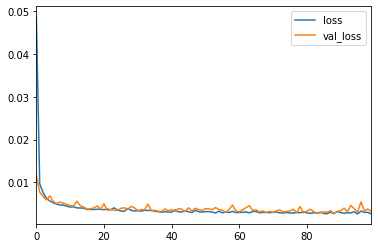

In [16]:
results = pd.DataFrame(history.history)
results.plot()

### 推論

In [20]:
start = 9100
sheed = np.reshape(raw_data[start:start+64],(1,64,1))
prediction = sheed

for i in range(20):
    res = model.predict(sheed)
    sheed = np.concatenate((sheed[:, 16:, :], res), axis=1)
    prediction = np.concatenate((prediction, res), axis=1)

(1, 384, 1)
(384,)


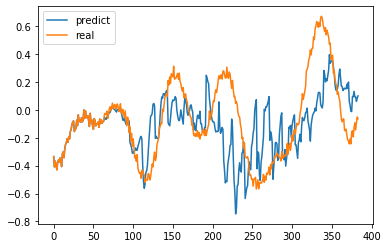

In [23]:
print(prediction.shape)
predictor = np.reshape(prediction, (-1))
print(predictor.shape)
plt.plot(range(len(predictor)), predictor, label='predict')
plt.plot(range(len(predictor)), raw_data[start:start + len(predictor)], label='real')
plt.legend() 
plt.show()

In [27]:
raw_data[100:200].shape

(100,)